In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np 
from scipy import stats
from lightgbm import LGBMClassifier

In [2]:
data=pd.read_csv("employee_details.csv")

In [3]:
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,76466,Sales & Marketing,region_31,Bachelor's,f,other,1,34,3.0,7,0,0,52,0
1,46459,Technology,region_2,Bachelor's,f,other,1,50,3.0,19,0,0,76,0
2,11890,Technology,region_7,Bachelor's,m,other,1,40,3.0,7,0,0,79,0
3,76483,Sales & Marketing,region_2,Bachelor's,f,sourcing,1,33,5.0,6,0,0,48,0
4,63365,Procurement,region_17,Bachelor's,f,other,1,34,3.0,8,0,0,67,0


# Basic Analysis

In [4]:
print(data.shape)

print((data.memory_usage().sum()/(1024*1024)).round(2), "MB")

(43846, 14)
4.68 MB


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43846 entries, 0 to 43845
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           43846 non-null  int64  
 1   department            43846 non-null  object 
 2   region                43846 non-null  object 
 3   education             41905 non-null  object 
 4   gender                43846 non-null  object 
 5   recruitment_channel   43846 non-null  object 
 6   no_of_trainings       43846 non-null  int64  
 7   age                   43846 non-null  int64  
 8   previous_year_rating  40521 non-null  float64
 9   length_of_service     43846 non-null  int64  
 10  KPIs_met >80%         43846 non-null  int64  
 11  awards_won?           43846 non-null  int64  
 12  avg_training_score    43846 non-null  int64  
 13  is_promoted           43846 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 4.7+ MB


In [6]:
data.describe() 

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,43846.000000,43846.000000,43846.000000,40521.000000,43846.000000,43846.000000,43846.000000,43846.000000,43846.000000
mean,39189.407198,1.251950,34.812503,3.327114,5.867057,0.351868,0.022807,63.348128,0.085162
std,22578.548145,0.609719,7.662864,1.259761,4.273456,0.477558,0.149290,13.359844,0.279125
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19655.250000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39262.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58710.750000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [7]:
name_mapping={"KPIs_met >80%":"KPI","awards_won?":"awards_won"}

In [8]:
data=data.rename(columns=name_mapping)

In [9]:
data.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPI', 'awards_won', 'avg_training_score',
       'is_promoted'],
      dtype='object')

In [10]:
data.dtypes.reset_index().rename(columns={'index': 'column_name', 0: 'dtype'})

,column_name,dtype
0,employee_id,int64
1,department,object
2,region,object
3,education,object
4,gender,object
5,recruitment_channel,object
6,no_of_trainings,int64
7,age,int64
8,previous_year_rating,float64
9,length_of_service,int64


In [11]:
data.isnull().sum()

employee_id                0
department                 0
region                     0
education               1941
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    3325
length_of_service          0
KPI                        0
awards_won                 0
avg_training_score         0
is_promoted                0
dtype: int64

In [12]:
missing_value_percentage=100*data.isnull().sum()/len(data)
print(missing_value_percentage)

employee_id             0.000000
department              0.000000
region                  0.000000
education               4.426858
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.583360
length_of_service       0.000000
KPI                     0.000000
awards_won              0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64


In [13]:
numeric_columns=data.select_dtypes(include={'int','float'}).columns
categorical_columns=data.select_dtypes(include={'object'}).columns

In [14]:
numeric_columns

Index(['employee_id', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPI', 'awards_won', 'avg_training_score',
       'is_promoted'],
      dtype='object')

In [15]:
columns_name=[ 'no_of_trainings', 'age', 'previous_year_rating',
      'length_of_service', 'KPI', 'awards_won', 'avg_training_score',]

In [16]:
categorical_columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel'], dtype='object')

In [17]:
data['previous_year_rating']=data['previous_year_rating'].replace(np.NaN,data['previous_year_rating'].median())

In [18]:
#data['education']=data['education'].replace(np.NaN,data['education'].mode())

#print('Dataset before :', len(data))
#data.dropna(subset=['education'],how='any',inplace=True)
#print('Dataset after :', len(data))
#print('missing values :',data['education'].isnull().sum())

#for col in categorical_columns:
 #   missing_sum=data[col].isnull().sum()
  #  if missing_sum>0:
   #     mode=data[col].mode()[0]
data["education"]=data["education"].fillna(data["education"].mode()[0])

In [19]:
data.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPI                     0
awards_won              0
avg_training_score      0
is_promoted             0
dtype: int64

# Univariate Analysis

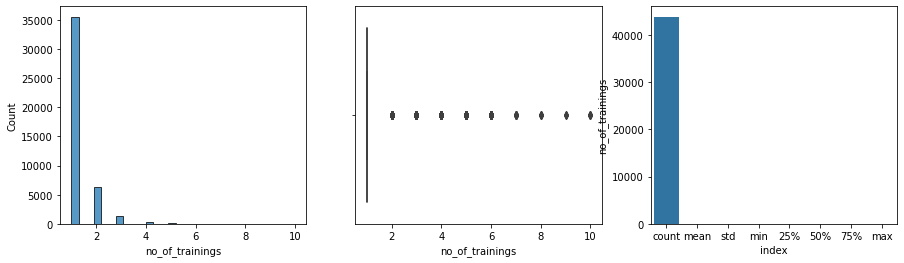

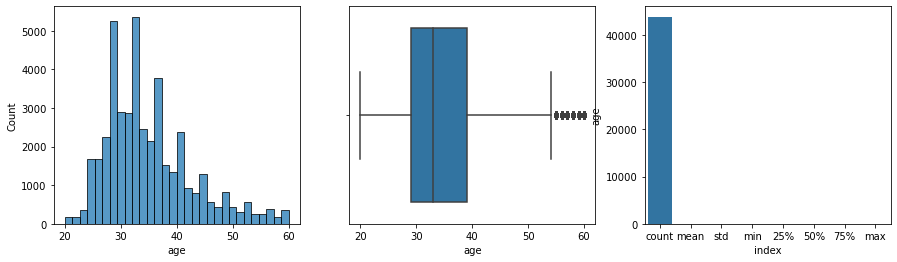

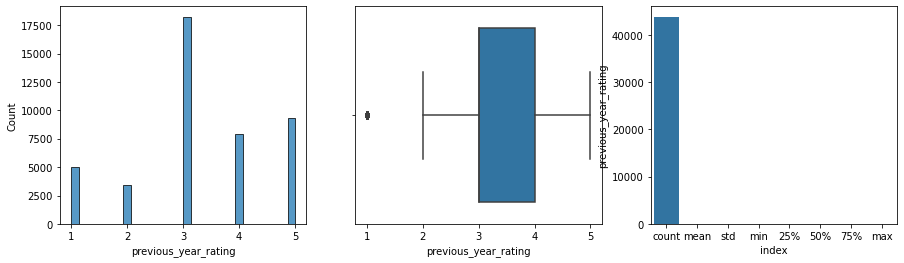

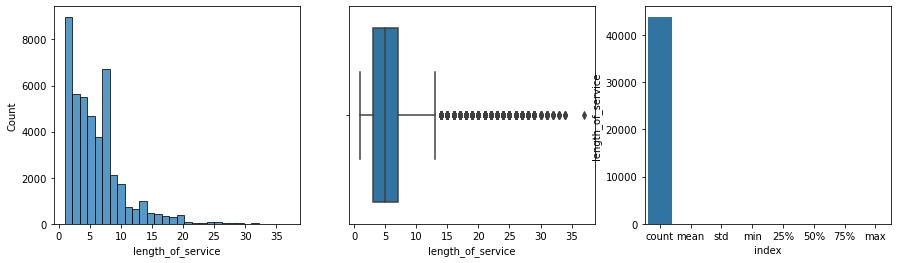

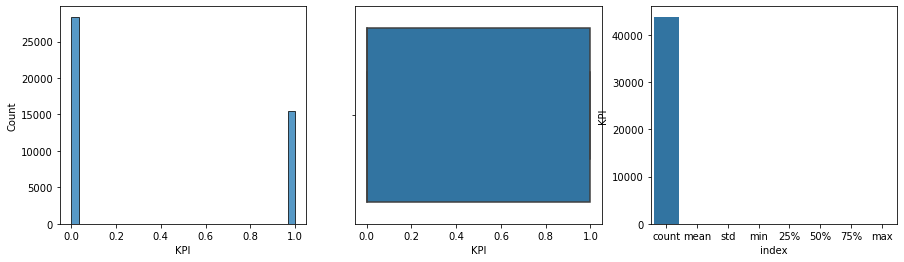

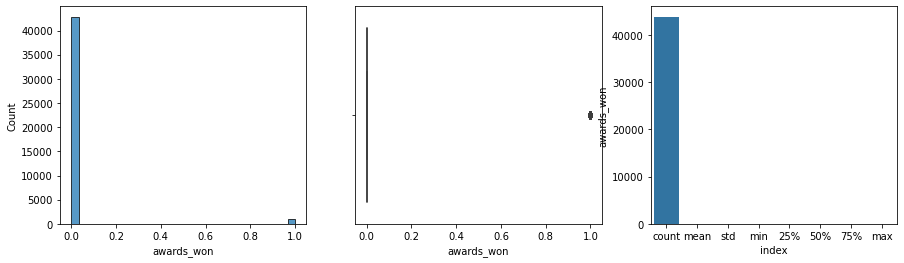

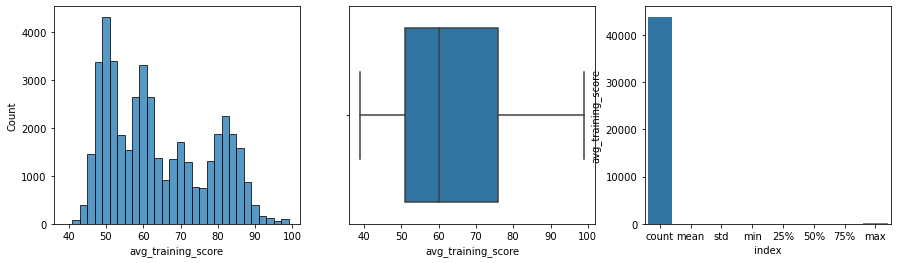

In [20]:

for col in columns_name:
    fig, axs = plt.subplots(1,3,figsize=(15,4))
    sns.histplot(data=data,x=col,bins=30,ax=axs[0])
    sns.boxplot(x=data[col],ax=axs[1])
    sns.barplot(data=data[col].describe().reset_index(),x='index',y=col,ax=axs[2]) 

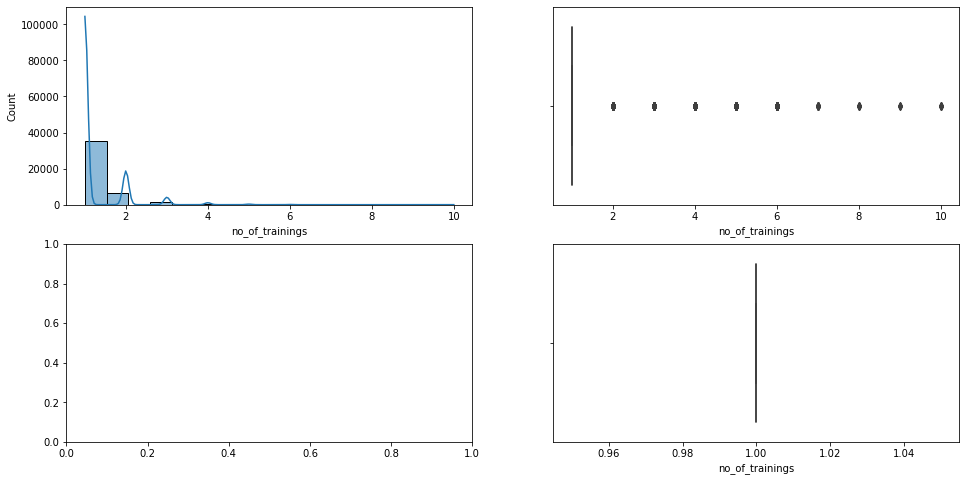

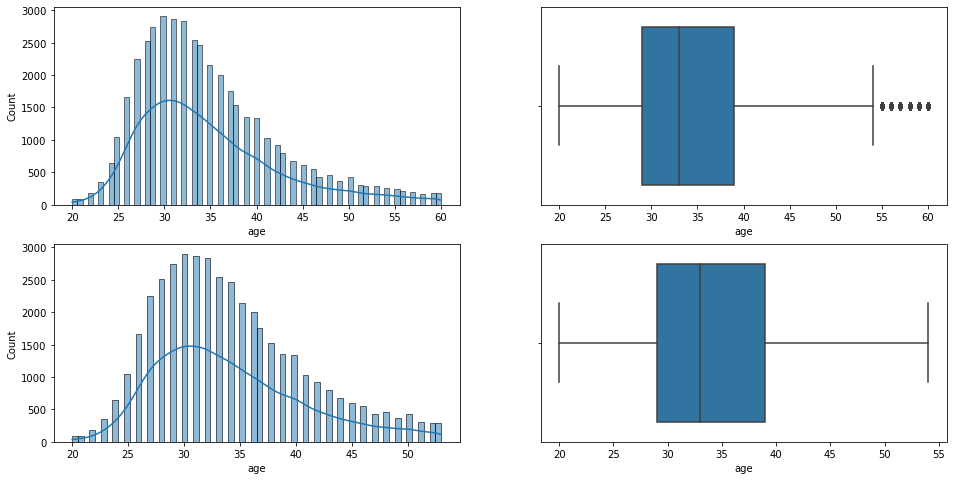

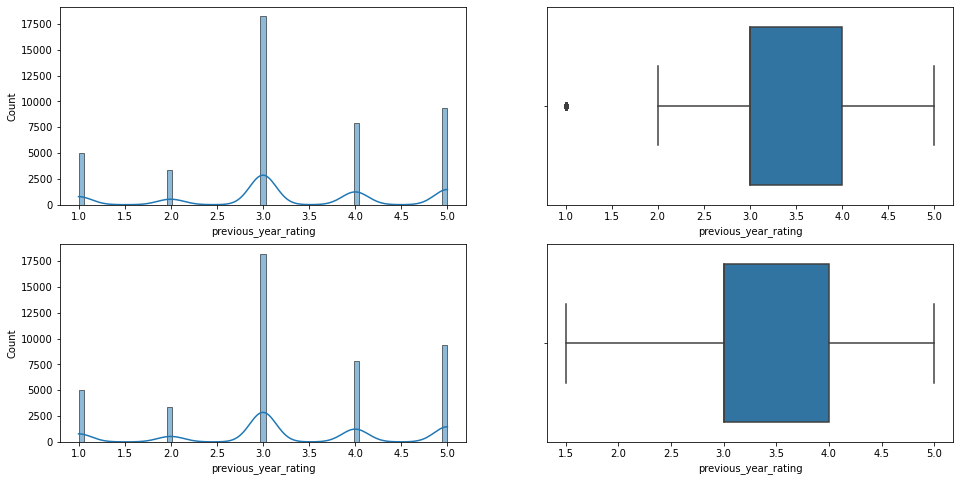

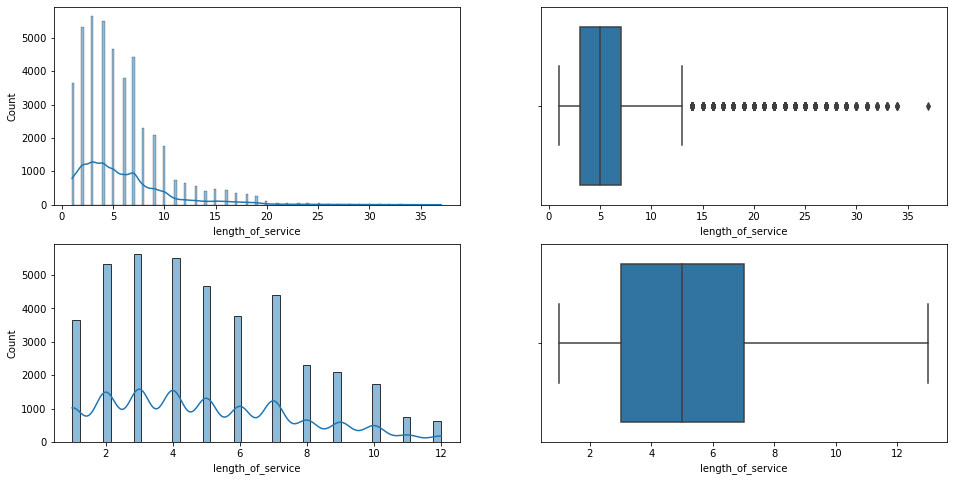

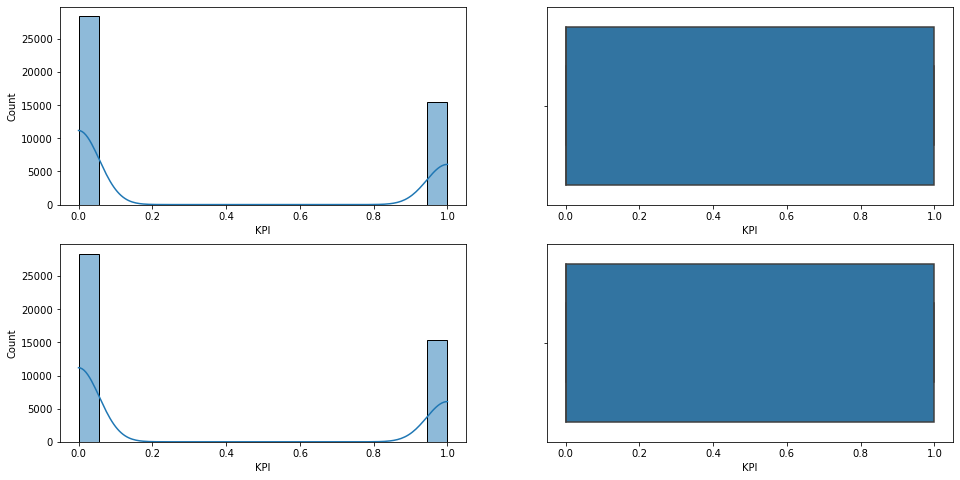

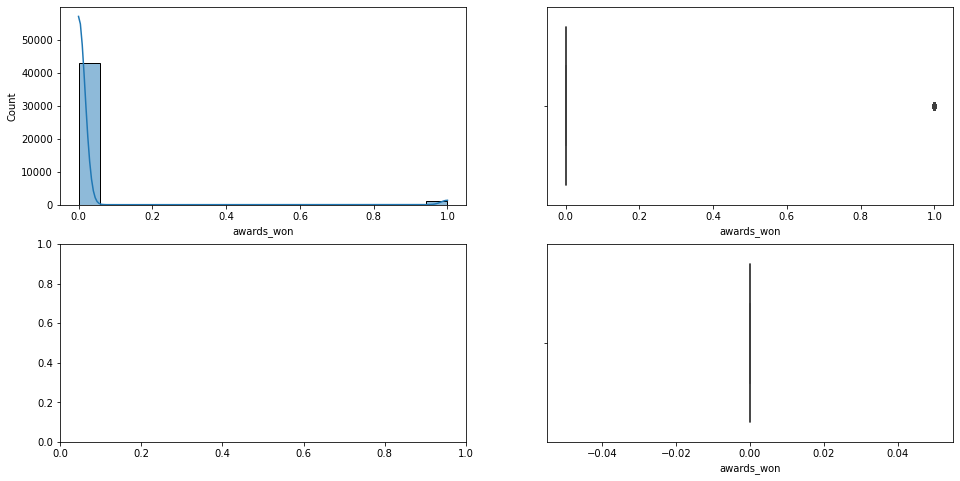

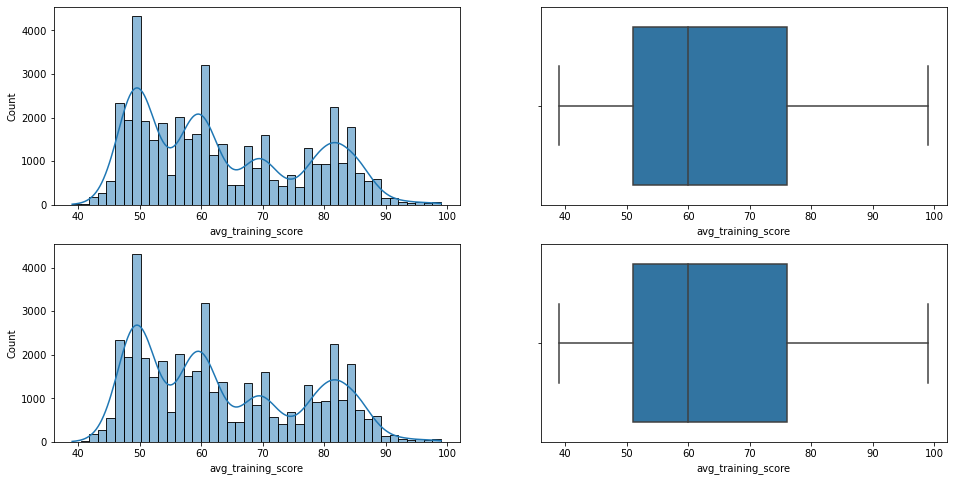

In [21]:

for col in columns_name:
    percentile25 = data[col].quantile(0.25)
    percentile75 = data[col].quantile(0.75)
    IQR = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * IQR
    lower_limit = percentile25 - 1.5 * IQR
    data[data[col] > upper_limit]
    data[data[col] < lower_limit]
    
    new_data = data[data[col] < upper_limit]
    new_data_cap = data.copy()
    new_data_cap[col] = np.where(
        new_data_cap[col] > upper_limit,
        upper_limit,
        np.where(
        new_data_cap[col] < lower_limit,
            lower_limit,
            new_data_cap[col]
        )
    )
    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    sns.histplot(data[col],kde=True)
    plt.subplot(2,2,2)
    sns.boxplot(data[col])
    plt.subplot(2,2,3)
    sns.histplot(new_data[col],kde=True)
    plt.subplot(2,2,4)
    sns.boxplot(new_data_cap[col])
    plt.show()

# Bivariate Analysis

<AxesSubplot:>

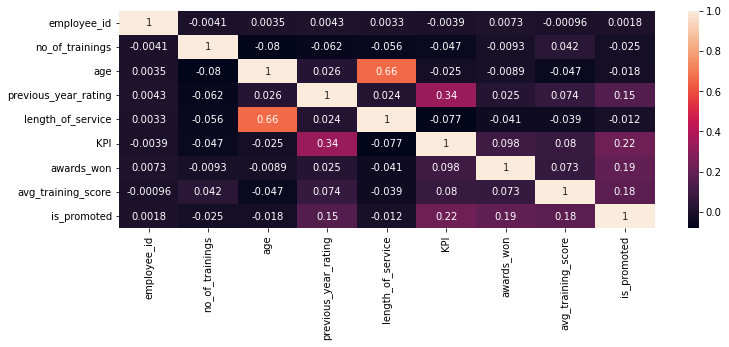

In [22]:
plt.figure(figsize=(12,4))
sns.heatmap(data.corr(),annot=True)

<AxesSubplot:xlabel='previous_year_rating', ylabel='is_promoted'>

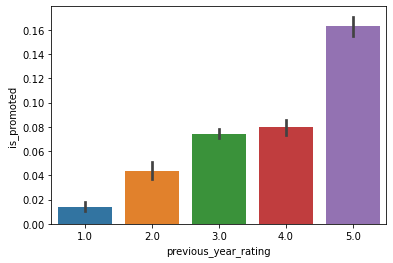

In [23]:
sns.barplot(data=data,x='previous_year_rating',y='is_promoted')

<AxesSubplot:xlabel='KPI', ylabel='is_promoted'>

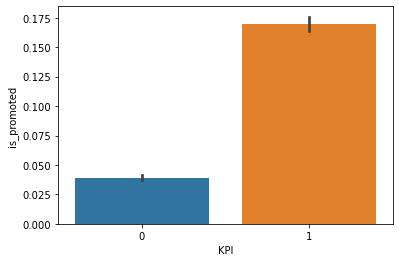

In [24]:
sns.barplot(data=data,x='KPI',y='is_promoted')

In [25]:
col=['no_of_trainings','department','gender','education']

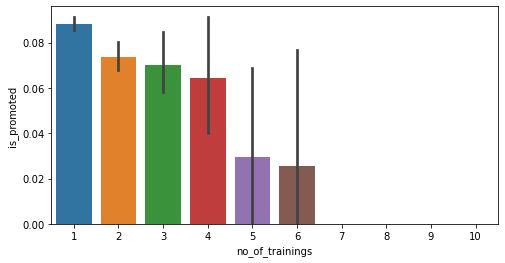

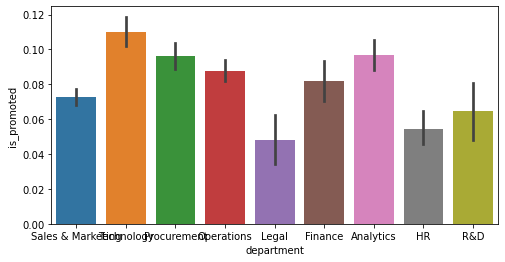

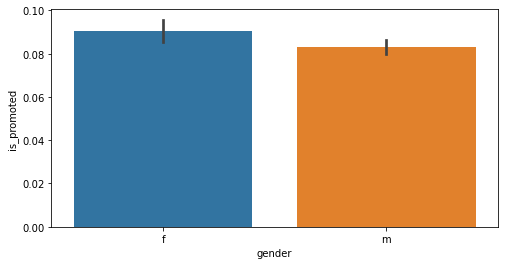

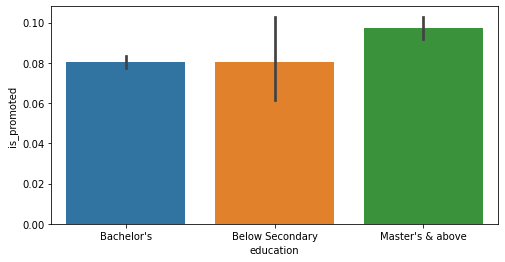

In [26]:
for i in col:
    fig, axs = plt.subplots(1,1,figsize=(8,4))
    sns.barplot(data=data,y='is_promoted',x=i)

<AxesSubplot:xlabel='KPI', ylabel='count'>

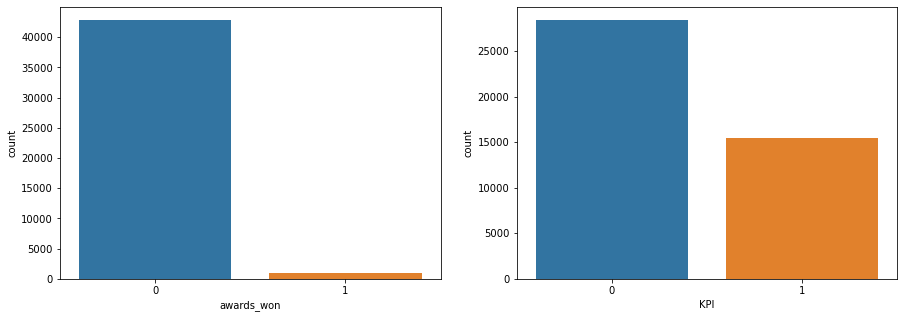

In [27]:
plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data['awards_won'])
plt.subplot(1,2,2)
sns.countplot(data['KPI'])

In [28]:
awards_and_KPI=data.loc[(data['KPI']==1) & (data['awards_won']==1)] 

In [29]:
awards_and_KPI

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPI,awards_won,avg_training_score,is_promoted
801,28986,Technology,region_2,Master's & above,m,sourcing,1,45,4.0,7,1,1,98,1
872,29028,Sales & Marketing,region_11,Master's & above,m,sourcing,1,37,4.0,4,1,1,52,0
910,67328,Operations,region_32,Bachelor's,m,other,1,35,4.0,4,1,1,74,1
996,58097,Analytics,region_32,Bachelor's,m,other,4,31,5.0,3,1,1,85,0
1027,49728,Technology,region_2,Bachelor's,m,sourcing,1,26,5.0,2,1,1,79,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43637,38484,Sales & Marketing,region_2,Master's & above,f,sourcing,2,36,1.0,3,1,1,54,0
43661,18231,Technology,region_7,Master's & above,m,referred,1,47,3.0,5,1,1,77,0
43665,76236,Technology,region_22,Bachelor's,f,other,1,28,4.0,4,1,1,79,1
43796,62923,Operations,region_13,Master's & above,f,other,1,38,5.0,2,1,1,93,1


<AxesSubplot:xlabel='is_promoted', ylabel='count'>

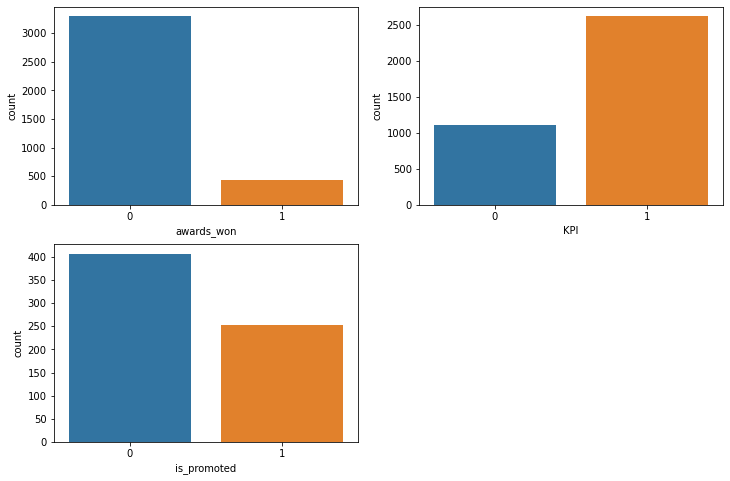

In [30]:
plt.subplots(figsize=(12,8))
plt.subplot(2,2,1)
sns.countplot(data[data.is_promoted == 1].awards_won)
plt.subplot(2,2,2)
sns.countplot(data[data.is_promoted == 1].KPI)
plt.subplot(2,2,3)
sns.countplot(awards_and_KPI.is_promoted)

In [31]:
data['awards_or_KPI'] = data[['KPI','awards_won']].any(axis=1,skipna=False)

In [32]:
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPI,awards_won,avg_training_score,is_promoted,awards_or_KPI
0,76466,Sales & Marketing,region_31,Bachelor's,f,other,1,34,3.0,7,0,0,52,0,False
1,46459,Technology,region_2,Bachelor's,f,other,1,50,3.0,19,0,0,76,0,False
2,11890,Technology,region_7,Bachelor's,m,other,1,40,3.0,7,0,0,79,0,False
3,76483,Sales & Marketing,region_2,Bachelor's,f,sourcing,1,33,5.0,6,0,0,48,0,False
4,63365,Procurement,region_17,Bachelor's,f,other,1,34,3.0,8,0,0,67,0,False


Text(0, 0.5, 'number of employees')

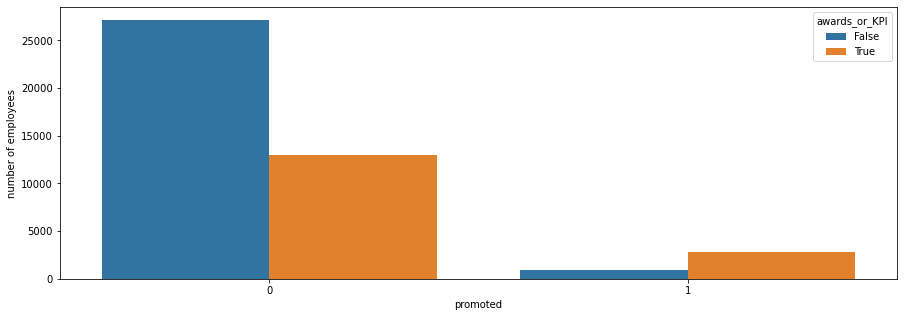

In [33]:
plt.figure(figsize=(15,5))
sns.countplot(data.is_promoted,hue=data.awards_or_KPI)
plt.xlabel('promoted')
plt.ylabel('number of employees')

In [34]:
data['total_trainings_score'] = data['no_of_trainings'] * data['avg_training_score']
data.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPI,awards_won,avg_training_score,is_promoted,awards_or_KPI,total_trainings_score
0,76466,Sales & Marketing,region_31,Bachelor's,f,other,1,34,3.0,7,0,0,52,0,False,52
1,46459,Technology,region_2,Bachelor's,f,other,1,50,3.0,19,0,0,76,0,False,76
2,11890,Technology,region_7,Bachelor's,m,other,1,40,3.0,7,0,0,79,0,False,79
3,76483,Sales & Marketing,region_2,Bachelor's,f,sourcing,1,33,5.0,6,0,0,48,0,False,48
4,63365,Procurement,region_17,Bachelor's,f,other,1,34,3.0,8,0,0,67,0,False,67


In [35]:
data['total_trainings_score_category'] = pd.cut(data.total_trainings_score,bins=[0,70,150,1000],labels=['Low','Medium','High'])
data.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPI,awards_won,avg_training_score,is_promoted,awards_or_KPI,total_trainings_score,total_trainings_score_category
0,76466,Sales & Marketing,region_31,Bachelor's,f,other,1,34,3.0,7,0,0,52,0,False,52,Low
1,46459,Technology,region_2,Bachelor's,f,other,1,50,3.0,19,0,0,76,0,False,76,Medium
2,11890,Technology,region_7,Bachelor's,m,other,1,40,3.0,7,0,0,79,0,False,79,Medium
3,76483,Sales & Marketing,region_2,Bachelor's,f,sourcing,1,33,5.0,6,0,0,48,0,False,48,Low
4,63365,Procurement,region_17,Bachelor's,f,other,1,34,3.0,8,0,0,67,0,False,67,Low


In [36]:
from sklearn.utils import resample

In [37]:
df_major=data[(data['is_promoted']==0)]
df_minor=data[(data['is_promoted']==1)]
df_major_sample=resample(df_major,replace=True,n_samples=3734,random_state=121)
df_upsample=pd.concat([df_major_sample,df_minor])

In [38]:
df_upsample['is_promoted'].value_counts()

0    3734
1    3734
Name: is_promoted, dtype: int64

In [39]:
drop_column=['region','gender','recruitment_channel','age','no_of_trainings','length_of_service']

In [40]:
data.drop(drop_column,axis=1,inplace=True)
data.head(5)

,employee_id,department,education,previous_year_rating,KPI,awards_won,avg_training_score,is_promoted,awards_or_KPI,total_trainings_score,total_trainings_score_category
0,76466,Sales & Marketing,Bachelor's,3.0,0,0,52,0,False,52,Low
1,46459,Technology,Bachelor's,3.0,0,0,76,0,False,76,Medium
2,11890,Technology,Bachelor's,3.0,0,0,79,0,False,79,Medium
3,76483,Sales & Marketing,Bachelor's,5.0,0,0,48,0,False,48,Low
4,63365,Procurement,Bachelor's,3.0,0,0,67,0,False,67,Low


In [41]:
data.head()

,employee_id,department,education,previous_year_rating,KPI,awards_won,avg_training_score,is_promoted,awards_or_KPI,total_trainings_score,total_trainings_score_category
0,76466,Sales & Marketing,Bachelor's,3.0,0,0,52,0,False,52,Low
1,46459,Technology,Bachelor's,3.0,0,0,76,0,False,76,Medium
2,11890,Technology,Bachelor's,3.0,0,0,79,0,False,79,Medium
3,76483,Sales & Marketing,Bachelor's,5.0,0,0,48,0,False,48,Low
4,63365,Procurement,Bachelor's,3.0,0,0,67,0,False,67,Low


In [42]:
columns=['total_trainings_score_category','department','education','awards_or_KPI']

In [43]:
data=pd.get_dummies(data,columns=columns,drop_first=True)

In [44]:
data

,employee_id,previous_year_rating,KPI,awards_won,avg_training_score,is_promoted,total_trainings_score,total_trainings_score_category_Medium,total_trainings_score_category_High,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Below Secondary,education_Master's & above,awards_or_KPI_True
0,76466,3.0,0,0,52,0,52,0,0,0,0,0,0,0,0,1,0,0,0,0
1,46459,3.0,0,0,76,0,76,1,0,0,0,0,0,0,0,0,1,0,0,0
2,11890,3.0,0,0,79,0,79,1,0,0,0,0,0,0,0,0,1,0,0,0
3,76483,5.0,0,0,48,0,48,0,0,0,0,0,0,0,0,1,0,0,0,0
4,63365,3.0,0,0,67,0,67,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43841,28438,3.0,0,0,70,0,140,1,0,0,0,0,0,1,0,0,0,0,1,0
43842,52110,5.0,0,0,47,0,47,0,0,0,0,0,0,0,0,1,0,0,0,0
43843,62487,5.0,1,0,58,0,116,1,0,0,0,0,1,0,0,0,0,0,1,1
43844,42163,5.0,0,0,53,0,53,0,0,0,0,0,0,0,0,1,0,0,0,0


In [45]:
data.shape

(43846, 20)

In [46]:
data.columns

Index(['employee_id', 'previous_year_rating', 'KPI', 'awards_won',
       'avg_training_score', 'is_promoted', 'total_trainings_score',
       'total_trainings_score_category_Medium',
       'total_trainings_score_category_High', 'department_Finance',
       'department_HR', 'department_Legal', 'department_Operations',
       'department_Procurement', 'department_R&D',
       'department_Sales & Marketing', 'department_Technology',
       'education_Below Secondary', 'education_Master's & above',
       'awards_or_KPI_True'],
      dtype='object')

In [47]:
drop_column1=['is_promoted']

In [48]:
from sklearn.tree import DecisionTreeClassifier
model= DecisionTreeClassifier(criterion='entropy', random_state=121)  
#from sklearn.linear_model import LogisticRegression
#model=LogisticRegression()

In [49]:
target='is_promoted'
features=['employee_id','previous_year_rating', 'KPI', 'awards_won', 'avg_training_score',
       'total_trainings_score',
       'total_trainings_score_category_Medium',
       'total_trainings_score_category_High', 'department_Finance',
       'department_HR', 'department_Legal', 'department_Operations',
       'department_Procurement', 'department_R&D',
       'department_Sales & Marketing', 'department_Technology',
       'education_Below Secondary', "education_Master's & above",
       'awards_or_KPI_True']

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
train_x,test_x,train_y,test_y=train_test_split(data[features],data[target],test_size=0.2,random_state=121)

In [52]:
train_x.shape,test_x.shape

((35076, 19), (8770, 19))

In [53]:
model=model.fit(train_x,train_y)

In [54]:
train_predict=model.predict(train_x)

In [55]:
test_predict=model.predict(test_x)

In [56]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [57]:
print(classification_report(test_y,test_predict))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      8009
           1       0.41      0.41      0.41       761

    accuracy                           0.90      8770
   macro avg       0.68      0.68      0.68      8770
weighted avg       0.90      0.90      0.90      8770



In [58]:
data[target]

0        0
1        0
2        0
3        0
4        0
        ..
43841    0
43842    0
43843    0
43844    0
43845    0
Name: is_promoted, Length: 43846, dtype: int64

In [59]:
model.predict(data[features])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [60]:
train_predictions=pd.DataFrame({'actual':data[target],'predictions':model.predict(data[features])})

In [61]:
train_predictions

,actual,predictions
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
43841,0,0
43842,0,0
43843,0,0
43844,0,0


In [62]:
train_predictions

,actual,predictions
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
43841,0,0
43842,0,0
43843,0,0
43844,0,0


In [63]:
df=pd.read_csv("test.csv")

In [64]:
df

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,13463,Technology,region_7,Bachelor's,m,sourcing,1,33,4.0,7,0,0,79
1,16160,Technology,region_23,Bachelor's,m,other,1,40,3.0,5,1,1,79
2,15840,Analytics,region_19,Bachelor's,m,other,1,40,3.0,5,0,0,86
3,28325,Procurement,region_27,Bachelor's,f,sourcing,3,26,3.0,2,1,1,69
4,23651,Sales & Marketing,region_6,Bachelor's,m,sourcing,1,29,4.0,6,0,0,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10957,53935,Technology,region_2,Master's & above,f,other,1,55,5.0,12,1,0,79
10958,52532,Finance,region_13,Master's & above,f,other,1,32,3.0,5,0,0,60
10959,39429,Technology,region_27,Master's & above,m,other,2,36,4.0,2,0,0,77
10960,48327,Technology,region_5,Bachelor's,m,sourcing,1,24,NaN,1,1,0,80


In [65]:
df.shape

(10962, 13)

In [66]:
df.isnull().sum()

employee_id               0
department                0
region                    0
education               468
gender                    0
recruitment_channel       0
no_of_trainings           0
age                       0
previous_year_rating    799
length_of_service         0
KPIs_met >80%             0
awards_won?               0
avg_training_score        0
dtype: int64

In [67]:
df['previous_year_rating']=df['previous_year_rating'].replace(np.NaN,df['previous_year_rating'].median())

In [68]:
df["education"]=df["education"].fillna(df["education"].mode()[0])

In [69]:
df.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
dtype: int64

In [70]:
name_mapping_df={"KPIs_met >80%":"KPI","awards_won?":"awards_won"}

In [71]:
df=df.rename(columns=name_mapping_df)

In [72]:
df.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPI', 'awards_won', 'avg_training_score'],
      dtype='object')

In [73]:
df['awards_or_KPI'] = df[['KPI','awards_won']].any(axis=1,skipna=False)

In [74]:
df['total_trainings_score'] = df['no_of_trainings'] * df['avg_training_score']

In [75]:
df['total_trainings_score_category'] = pd.cut(df.total_trainings_score,bins=[0,70,150,1000],labels=['Low','Medium','High'])

In [76]:
drop_column=['region','gender','recruitment_channel','age','no_of_trainings','length_of_service']

In [77]:
df.drop(drop_column,axis=1,inplace=True)

In [78]:
df.head()

,employee_id,department,education,previous_year_rating,KPI,awards_won,avg_training_score,awards_or_KPI,total_trainings_score,total_trainings_score_category
0,13463,Technology,Bachelor's,4.0,0,0,79,False,79,Medium
1,16160,Technology,Bachelor's,3.0,1,1,79,True,79,Medium
2,15840,Analytics,Bachelor's,3.0,0,0,86,False,86,Medium
3,28325,Procurement,Bachelor's,3.0,1,1,69,True,207,High
4,23651,Sales & Marketing,Bachelor's,4.0,0,0,50,False,50,Low


In [79]:
columns=['total_trainings_score_category','department','education','awards_or_KPI']

In [80]:
df=pd.get_dummies(df,columns=columns,drop_first=True)

In [81]:
df.head()

,employee_id,previous_year_rating,KPI,awards_won,avg_training_score,total_trainings_score,total_trainings_score_category_Medium,total_trainings_score_category_High,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Below Secondary,education_Master's & above,awards_or_KPI_True
0,13463,4.0,0,0,79,79,1,0,0,0,0,0,0,0,0,1,0,0,0
1,16160,3.0,1,1,79,79,1,0,0,0,0,0,0,0,0,1,0,0,1
2,15840,3.0,0,0,86,86,1,0,0,0,0,0,0,0,0,0,0,0,0
3,28325,3.0,1,1,69,207,0,1,0,0,0,0,1,0,0,0,0,0,1
4,23651,4.0,0,0,50,50,0,0,0,0,0,0,0,0,1,0,0,0,0


In [82]:
df

,employee_id,previous_year_rating,KPI,awards_won,avg_training_score,total_trainings_score,total_trainings_score_category_Medium,total_trainings_score_category_High,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Below Secondary,education_Master's & above,awards_or_KPI_True
0,13463,4.0,0,0,79,79,1,0,0,0,0,0,0,0,0,1,0,0,0
1,16160,3.0,1,1,79,79,1,0,0,0,0,0,0,0,0,1,0,0,1
2,15840,3.0,0,0,86,86,1,0,0,0,0,0,0,0,0,0,0,0,0
3,28325,3.0,1,1,69,207,0,1,0,0,0,0,1,0,0,0,0,0,1
4,23651,4.0,0,0,50,50,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10957,53935,5.0,1,0,79,79,1,0,0,0,0,0,0,0,0,1,0,1,1
10958,52532,3.0,0,0,60,60,0,0,1,0,0,0,0,0,0,0,0,1,0
10959,39429,4.0,0,0,77,154,0,1,0,0,0,0,0,0,0,1,0,1,0
10960,48327,3.0,1,0,80,80,1,0,0,0,0,0,0,0,0,1,0,0,1


In [83]:
test_predict_df=model.predict(df)

In [84]:
test_predict_df

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [85]:
test_prediction_on_test_data=pd.DataFrame({'employee_id':df['employee_id'],'tast_data_predicted':test_predict_df})

In [86]:
sample_file=pd.read_csv('sample_submission.csv')

In [87]:
sample_file.head()

,employee_id,is_promoted
0,13463,NaN
1,16160,NaN
2,15840,NaN
3,28325,NaN
4,23651,NaN


In [88]:
sample_file['is_promoted']=test_predict_df

In [89]:
sample_file.to_csv('sample_file.csv',index=False)

In [90]:
sample_file.head()

,employee_id,is_promoted
0,13463,0
1,16160,0
2,15840,0
3,28325,0
4,23651,0
